# Learning Best Practices for Model Evaluation and Hyperparameter Tuning

In the previous chapter, you learned about the essential machine learning algorithms for classification and how to get our data into shape before we feed it into those algorithms. Now, it's time to learn about the best practices of building good machine learning models by fine-tuning the algorithms and evaluating the model's performance. In this chapter, we will learn how to do the following:
* Obtain unbiased estimates of a model's performance. 
* Diagnose the common problems of machine learning algorithms. 
* Fine-tune machine learning models. 
* Evaluate predictive models using different performance metrics. 

# Streamlining workflows with pipelines

When we applied different preprocessing techniques in the previous chapters, such as standardization for feature scale or principal component analysis for data compression, you learned that we have to reuse the parameters that we obtained during the fitting of the training data to scale and compress any new data, such as the samples in the separate test dataset. In this section, you will learn about an extremely handy tool, the *Pipeline* class in scikit-learn. It allows us to fit a model including an arbitrary number of transformation steps and apply it to make predictions about new data. 

# Loading the Breast Cancer Wisconsin dataset

In this chapter, we will be working with the Breast Cancer Wisconsin dataset, which contains 569 samples of malignant and benign tumor cells. The first two columns in the dataset store the unique ID numbers of the samples and the corresponding diagnoses (*M* = malignant, *B* = belign), respectively. Columns 3-32 contain 30 real-valued features that have been computed from digitized images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant. The Breast Cancer Wisconsin dataset has been deposited in the UCI Machine Learning Repository. 

In this section, we willl read the dataset and split it to training and test datasets in three simple steps: 

* We will start by reading in the dataset using *pandas*: 

In [ ]:
import pandas as pd

# df = pd.read_csv('https://archive.ics.uci.edu/ml/'
#                  'machine-learning-databases/'
#                  'breast-cancer-wisconsin/'
#                  'wdbc.data')
df = pd.read_csv('wdbc.data', header=None)

* Next, we assign the 30 features to a NumPy array *x*. Using a *LabelEncoder* object, we transform the class labels from their original string representation ('M' and 'B') into integer: 

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

After encoding the class labels (diagnosis) in an array *y*, the malignant tumors are now represented as class 1, and the benign tumors are represented as class 0, respectively. We can double-check this mapping by calling the *transform* method of the fitted *LabelEncoder* on two dummy class labels: 

In [3]:
le.transform(['M', 'B'])

array([1, 0])

* Before we construct our first model pipeline in the following subsection, let us divide the dataset into a separate training dataset (80 percent of the data) and a separate test dataset (20 percent of the data): 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, stratify=y, 
                     random_state=1)

# Combining transformers and estimators in a pipeline

In the previous chapter, you learned that many learning algorithms require input features on the same scale for optimal performance. Thus, we need to standardize the columns in the Breast Cancer Wisconsin dataset before we can feed them to a linear classifier, such as logistic regression. Furthermore, let's assume that we want to compress our data from the initial 30 dimensions onto a lower two-dimensional subspace via **Principal Component Analysis (PCA)**, a feature extraction technique for dimensionality reduction. 

Instead of going though the fitting and transformation steps for the training and test datasets separately, we can chain the *StandardScaler*, *PCA* and *LogisticRegression* objects in a pipeline: 

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), 
                        PCA(n_components=2), 
                        LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


The *make_pipeline* function takes an arbitrary number of scikit-learn transformers (objects that support the *fit* and *transform* methods as input), followed by a scikit-learn estimator that implements the *fit* and *predict* methods. In our preceding code example, we provided two transformers, *StandardScaler* and *PCA*, and a *LogisticRegression* estimator as inputs to the *make_pipeline* function, which constructs a scikit-learn *Pipeline* object from these objects. 

We can think of a scikit-learn *Pipeline* as a meta-estimator or wrapper around those individual transformers and estimators. If we call the *fit* method of *Pipeline*, the data will be passed down a series of transformers via *fit* and *transform* calls on these intermediate steps until it arrives at the estimator object (the final element in a pipeline). The estimator will then be fitted to the transformed training data. 

We we executed the *fit* method on the *pipe_lr* pipeline in the preceding code example, *StandardScaler* first performed *fit* and *transform* calls on the training data. Second, the transformed training data was passed on to the next object in the pipeline, *PCA*. Similar to the previous step, *PCA* also executed *fit* and *transform* on the scaled input data and passed it to the final element of the pipeline, the estimator. 

Finally, the *LogisticRegression* estimator was fit to the training data after it underwent transformations via *StandardScaler* and *PCA*. Again, we should note that there is no limit to the number of intermediate steps in a pipeline; however, the last pipeline element has to be an esimator. 

Similar to calling *fit* on the pipeline, pipelines also implement a *predict* method. If we feed a dataset to the *predict* call of a *Pipeline* object instance, the data will be pass through the intermediate steps via *transform* calls. In the final step, the estimator object will then return a prediction on the transformed data. 

The pipelines of scikit-learn library are immensely useful wrapper tools, which we will use frequently throughout the rest of this book. To make sure that you have got a good grasp of how *Pipeline* objects works, please take a close look at the following illustration, which summarize our discussion from the previous paragraphs: 

<img src='images/06_01.png'>

# Using k-fold cross-validation to assess model performance 

One of the key steps in building a machine learning model is to estimate its performance on data that the model has not seen before. Let's assume that we fit our model on training dataset and use the same data to estimate how well it performs on new data. We remember that a model can either suffer from underfitting (high bias) if the model is too simple, or it can overfit the training data (high variance) if the model is too complex for the underlying training data. 

To find an acceptable bias-variance trade-off, we need to evaluate our model carefully. In this section, you will learn about the common cross-validation techniques **holdout cross-validation** and **k-fold cross-validation**, which can help us obtain reliable estimates of the model's generalization performance, that is, how well the model performs on unseen data. 

## The holdout method 

A classic and popular approach for estimating the generalization performance of machine learning models is holdout cross-validation. Using the holdout method, we split our initial dataset into a separate training and test dataset, the former is used for model training, and the latter is used to estimate its generalization performance. However, in typical machine learning applications, we are also interested in tuning and comparing different parameter settings to further improve the performance for making predictions on unseen data. This process is called **model selection**, where the term model selection refers to a given classification problem for which we want to select the *optimal* values of tuning parameters (also called hyperparameters). However, if we reuse the same test dataset over and over again during the model selection, it will become part of our training data and thus the model will be more likely to overfit. Despite this issue, many people still use the test set for model selection, which is not a good machine learning practice. 

A better way of using the holdout method for model selection is to separate the data into three parts: a training set, a validation set, and a test set. The training set is used to fit the different models, and the performance on the validation set is then used for the model selection. The advantage of having a test set that the model has not seen before during the training and model selection steps is that we can obtain a less biased estimate of its ability to generalize to new data. The following figure illustrates the concept of holdout cross-validation, where we use a validation set to repeatedly evaluate the performance of the model after training using different parameter values. Once we are satisfied with the tuning of hyperparameter values, we estimate the model's generalization performance on the test dataset: 

<img src='images/06_02.png'>

A disadvantage of the holdout method is that the performance estimate may be very sensitive to how we partition the training set into the training and validation subsets; the estimate will vary for different samples of the data. In the next subsection, we will take a look at a more robust technique for performance estimation, **k-fold cross validation**, where we repeat the holdout method *k* times on *k*-subsets of the training data. 

## K-fold cross-validation

In k-fold cross-validation, we randomly split the training dataset into *k* folds without replacement, where $k-1$ folds are used for the model training, and one fold is used for performance evaluation. This procedure is repeated *k* times so that we obtain *k* models and performance estimates. 

We then calculate the average performance of the models based on the different, independent folds to obtain a performance estimate that is less sensitive to the sub-partitioning of the training data compared to the holdout method. Typically, we use k-fold cross-validation for model tuning, that is, findind the optimal hyperparameter values that yields a satisfying generalization performance. 

Once we have found satisfactory hyperparameter values, we can retrain the model on the complete training set and obtain a final performance estimate using the independent test set. The rationale behind fitting a model to the whole training dataset after k-fold cross-validation is that providing more training samples to a learning algorithm usually results in a more accurate and robust model. 

Since k-fold cross-validation is a resampling technique without replacement, the advantage of this approach is that each sample point will be used for training and validation (as part of a test fold) exactly once, which yields a lower-variance estimate of the model performance than the holdout method. The following figure summarizes the concept behind k-fold cross validation with $k=10$. The training dataset is divided into 10 folds, and during the 10 iterations, nine folds are used for training, and one fold will be used as the test set for the model evaluation. Also, the estimated performances $E_i$ (for example, classification accuracy or error) for each fold are then used to calculate the estimated average performance $E$ of the model: 

<img src='images/06_03.png'>

A good standard value for $k$ in k-fold cross-validation is 10, as empirical evidence showns. For instance, experiments by Ron Kohavi on various real-world datasets suggests that 10-fold cross-validation offers the best trade-off between bias and variance. 

However, if we are working with relatively small training sets, it can be useful to increase the number of folds. If we increase the value of $k$, more training data will be used in each iteration, which results in a lower bias towards estimating the generalization performance by averaging the individual model estimates. However, large values of $k$ will also increase the runtime of the cross-validation algorithm and yield estimates with higher variance, since the training folds will be more similar to each other. On the other hand, if we are working with large datasets, we can choose a small value of $k$, for example, $k=5$, and still obtain an accurate estimate of the average performance of the model while reducing the computational cost of refitting and evaluating the model on different folds. 

A special case of k-fold cross-validation is the **Leave-one-out cross-validation (LOOCV)** method. In LOOCV, we set the number of folds equal to the number of training samples ($k = n$) so that only training sample is used for testing during each iteration, which is a recommended approach for working with very small datasets. 

A slight improvement over the standard k-fold cross-validation approach is stratified k-fold cross-validation, which can yield better bias and variance estimates, especially in cases of unequal class proportions. In stratified cross-validation, the class proportions are preserved in each fold to ensure that each fold is representative of the class proportions in the training dataset, which we will illustrate by using the *StratifiedKFold* iterator in scikit-learn: 

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, 
                        random_state=1).split(X_train, 
                                              y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' 
          % (k+1, np.bincount(y_train[train]), score))
print('\nCV accuracy: %.3f +/- %.3f' 
      % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.014


First, we initialized the *StratifiedKFold* iterator from *sklearn.model_selection* module with the *y_train* class labels in the training set, and we specified the number of folds via the *n_splits* parameter. When we used the *kfold* iterator to loop through the *k* folds, we used the returned indices in *train* to fit the logistic regression pipeline that we set up at the beginning of this chapter. Using the *pipe_lr* pipeline, we ensured that the samples were scaled properly (for instance, standardized) in each iteration. We then used the *test* indices to calculate the accuracy score of the model, which we collected in the *scores* list to calculate the average accuracy and the standard deviation of the estimate. 

Although the previous code example was useful to illustrate how k-fold cross-validation works, scikit-learn also implements a k-fold cross-validation scores, which allows us to evaluate our model using stratified k-fold cross-validation less verbosely: 

In [7]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr, 
                         X=X_train, y=y_train, 
                         cv=10, n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


An extremely useful feature of the *cross_val_score* approach is that we can distribute the evaluation of the different folds across multiple CPUs on our machine. If we set the *n_jobs* parameter to 1, only one CPU will be used to evaluate the performances, just like in our *StratifiedKFold* example previously. However, by setting *n_jobs=2*, we could distribute the 10 rounds of cross-validation to two CPUs (if available on our machine), and by setting *n_jobs=-1*, we can use all available CPUs on our machine to do the computation in parallel. 

# Debugging algorithms with learning and validation curves

In this section, we will take a look at two very simple yet powerful diagnostic tools that can help us improve the performance of a learning algorithm: **learning curves** and **validation curves**. In the next subsections, we will discuss how we can use learning curves to diagnose whether a learning algorithm has a problem with overfitting (high variance) or underfitting (high bias). Furthermore, we will take a look at validation curves that can help us address the common issues of a learning algorithm. 

## Diagnosing bias and variance problems with learning curves

If a model is too complex for a given dataset, there are too many degrees of freedom or parameters in this model, the model tends to overfit the training data and does not generalize well to unseen data. Often, it can help to collect more training samples to reduce the degree of overfitting. However, in practice, it can often be very expensive or simply not feasible to collect more data. By plotting the model training and validation accuracies as functions of the training set size, we can easily detect whether the model suffers from high variance or high bias, and whether the collection of more data could help address this problem. But before, we discuss how to plot learning curves in scikit-learn, let's discuss those two common model issues by walking through the following illustration: 

<img src='images/06_04.png'>

The graph in the upper-left shows a model with high bias. This model has both low training and cross-validation accuracy, which indicates that it underfits the training data. Common ways to address this issue are to increase the number of parameters of the model, for example, by collecting or constructing additional features, or by decreasing the degree of regularization, for example, in SVM or logistic regression classifiers. 

The graph in the upper-right shows a model that suffers from high variance, which is indicated by the large gap between the training and cross-validation accuracy. To address this problem of overfitting, we can collect more training data, reduce the complexity of the model, or increase the regularization parameter, for example. For unregularized models, it can also help decrease the number of features via feature selection or feature extraction to decrease the degree of overfitting. While collecting more training data usually tends to decrease the chance of overfitting, it may not always help, for example, it the training data is extremely noisy or the model is already very close to optimal. 

In the next subsection, we will see how to address those model issues using validation curves, but let's first see how we can use the learning curve function from scikit learn to evaluate the model: 

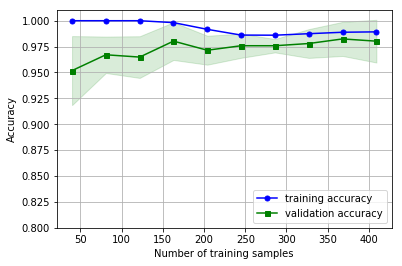

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), 
                        LogisticRegression(penalty='l2', 
                                           random_state=1))

train_sizes, train_scores, test_scores =\
    learning_curve(estimator=pipe_lr, 
                   X=X_train, y=y_train, 
                   train_sizes=np.linspace(0.1, 1.0, 10), 
                   cv=10, n_jobs=1)
    
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', 
         marker='o', markersize=5, 
         label='training accuracy')
plt.plot(train_sizes, test_mean, color='green', 
         marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, 
                 color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.01])
plt.show()

Via the *train_sizes* parameter in the *learning_curve* function, we can control the absolute or relative number of training samples that are used to generate the learning curves. Here, we set *train_sizes=np.linspace(0.1, 1.0, 10)* to use 10 evenly spaced, relative intervals for the training set sizes. By default, the *learning_curve* function uses stratified k-fold cross-validation to calculate the cross-validation accuracy of a classifier, and we set $k=10$ via the *cv* parameter for 10-fold stratified cross-validation. Then, we simply calculated the average accuracies from the returned cross-validated training and set scores for the different sizes of the training set, which we plotted using Matplotlib's *plot* function. Furthermore, we added the standard deviation of the average accuracy to the plot using the *fill_between* function to indicate the variance of the estimate. 

As we can see in the preceding learning curve plot, our model performs quite well on both the training and validation datasets if it had seen more than 250 samples during training. We can also see that the training accuracy increases for training sets with fewer than 250 samples, and the gap between validation and training accuracy widens, an indicator of an increasing degree of overfitting. 